# Building Machine Learning Datasets

All machine learning problems begin with a dataset, and before we can perform any kind of inference on that dataset we must create/wrangle/build it. This is often the most time-consuming and hard part of a successful machine learning workflow. There is no set procedure here, as all data is different, although there are a few simple methods we can take to make a useful dataset.

We will be using data from a submitted Manuscript (Butterworth and Barnett-Moore 2020) which was a finalist in the [Unearthed, ExploreSA: Gawler Challenge](https://unearthed.solutions/u/competitions/exploresa). You can visit the [original repo here](https://github.com/natbutter/gawler-exploration).


In [1]:
# import numpy as np
# import scipy
# from scipy import io
# import time
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs

# Goal: Create a table of data containing "targets" and "predictor variables"

The targets in an ML context can be a simple binary 1 or 0, or could be some category, or the value of a particular parameter. It is the "feature" of a dataset that we want to learn something about!

The "predictor/feature variables" are the quatities/parameters that may have some causal relationship with the the target.


## Step 1 - What is our target variable?
Are we classifying something? 

### Deposit locations - mine and mineral occurances
The most important dataset for this workflow is the currently known locations of mineral occurences. Using the data we already know about these known-deposits we will build a model to predict where future occurences will be.

In [2]:
# For working with shapefiles (packaged is called pyshp)
import shapefile
# For working with dataframes
import pandas as pd

In [3]:
# Set the filename
mineshape="data/MinesMinerals/mines_and_mineral_occurrences_all.shp"

# Set shapefile attributes and assign
sf = shapefile.Reader(mineshape)
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]

# Write into a dataframe for easy use
df = pd.DataFrame(columns=fields, data=records)

View the metadata of the [South Australian all mines and mineral deposits](https://catalog.sarig.sa.gov.au/geonetwork/srv/eng/catalog.search#/metadata/a0e4b62c-ec88-44b8-a530-b4e744a6b414) to get a better understanding for what features we could use as a target.

In [4]:
#See what the dataframe looks like
print(df.columns)

#For clean printing to html drop columns that contains annoying / and \ chars.
#And set max columns
pd.options.display.max_columns = 8
df.drop(columns=['REFERENCE','O_MAP_SYMB'])

Index(['MINDEP_NO', 'DEP_NAME', 'REFERENCE', 'COMM_CODE', 'COMMODS',
       'COMMOD_MAJ', 'COMM_SPECS', 'GCHEM_ASSC', 'DISC_YEAR', 'CLASS_CODE',
       'OPER_TYPE', 'MAP_SYMB', 'STATUS_VAL', 'SIZE_VAL', 'GEOL_PROV',
       'DB_RES_RVE', 'DB_PROD', 'DB_DOC_IMG', 'DB_EXV_IMG', 'DB_DEP_IMG',
       'DB_DEP_FLE', 'COX_CLASS', 'REG_O_CTRL', 'LOC_O_CTRL', 'LOC_O_COM',
       'O_LITH_CDE', 'O_LITH01', 'O_STRAT_NM', 'H_LITH_CDE', 'H_LITH02',
       'H_STRAT_NM', 'H_MAP_SYMB', 'EASTING', 'NORTHING', 'ZONE', 'LONGITUDE',
       'LATITUDE', 'SVY_METHOD', 'HORZ_ACC', 'SRCE_MAP', 'SRCE_CNTRE',
       'COMMENTS', 'O_MAP_SYMB'],
      dtype='object')


,MINDEP_NO,DEP_NAME,COMM_CODE,COMMODS,...,HORZ_ACC,SRCE_MAP,SRCE_CNTRE,COMMENTS
0,5219,MOUNT DAVIES NO.2A,Ni,Nickel,...,2000.0,500k meis,,
1,52,ONE STONE,Ni,Nickel,...,500.0,71-385,,
2,8314,HINCKLEY RANGE,Fe,Iron,...,500.0,,,
3,69,KALKA,"V, ILM","Vanadium, Ilmenite",...,100.0,1 MILE,mgt polygon on digital map,
4,65,ECHIDNA,Ni,Nickel,...,20.0,50K GEOL,DH ECHIDNA PROSPECT,
...,...,...,...,...,...,...,...,...,...
8672,6937,YARINGA,QTZE,Quartzite,...,200.0,50k moc,fenced yard,
8673,4729,WELCHS,SCHT,Schist,...,20.0,50k topo,,
8674,4718,ARCADIAN,CLAY,Clay,...,5.0,Plan 1951-0327,Pit,
8675,1436,MCDONALD,Au,Gold,...,200.0,50k moc,qz float,


In [5]:
#We are building a model to target South Australia, so load in a map of it.
gawlshape="data/SA/SA_STATE_POLYGON_shp"
shapeRead = shapefile.Reader(gawlshape)
shapes  = shapeRead.shapes()

#Save the boundary xy pairs in arrays we will use throughout the workflow
xval = [x[0] for x in shapes[1].points]
yval = [x[1] for x in shapes[1].points]

In [6]:
# Subset the data, for a single Mineral target
commname='Mn'

#Pull our all the occurences of the commodity and go from there
comm=df[df['COMM_CODE'].str.contains(commname)]
comm=comm.reset_index(drop=True)
print("Shape of "+ commname, comm.shape)

# Can make further subsets of the data here if needed
#commsig=comm[comm.SIZE_VAL!="Low Significance"]
#comm=comm[comm.SIZE_VAL!="Low Significance"]
#comm=comm[comm.COX_CLASS == "Olympic Dam Cu-U-Au"]
#comm=comm[(comm.lon<max(xval)) & (comm.lon>min(xval)) & (comm.lat>min(yval)) & (comm.lat<max(yval))]


Shape of Mn (115, 43)


In [7]:
# For plotting
import matplotlib.pyplot as plt

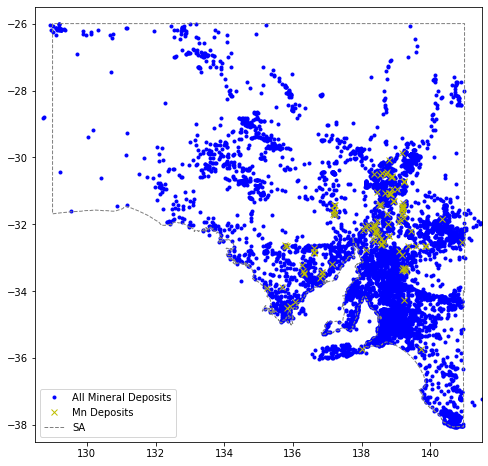

In [8]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.plot(df.LONGITUDE,df.LATITUDE,'b.',label="All Mineral Deposits")
ax.plot(comm.LONGITUDE,comm.LATITUDE,'yx',label=commname+" Deposits")

ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
#ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='o', linestyle='',markersize=5, color='y',label=commname+" Deposits")

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)
plt.legend(loc=3)

plt.show()

## Step 2 - Wrangle the geophysical and geological datasets (variable features)
Each geophysical dataset could offer instight into various commodities. Here we load in the pre-processed datasets and prepare them for further manipulations, data-mining, and machine learning.
All of the full datasets are availble from https://map.sarig.sa.gov.au/. For this exercise we have simplified the datasets (reduced complexity and resolution). Grab full datasets from [https://github.com/natbutter/gawler-exploration/tree/master/ML-DATA](https://github.com/natbutter/gawler-exploration/tree/master/ML-DATA)

### Resistivity xyz data

In [9]:
#Read in the data
data_res=pd.read_csv("data/AusLAMP_MT_Gawler_25.xyzr",
                     sep=',',header=0,names=['lat','lon','depth','resistivity'])
data_res

,lat,lon,depth,resistivity
0,-27.363931,128.680796,-25.0,2.0007
1,-27.659362,128.662322,-25.0,1.9979
2,-27.886602,128.647965,-25.0,1.9948
3,-28.061394,128.636833,-25.0,1.9918
4,-28.195844,128.628217,-25.0,1.9885
...,...,...,...,...
11003,-35.127716,142.399588,-25.0,2.0079
11004,-35.230939,142.408396,-25.0,2.0084
11005,-35.365124,142.419903,-25.0,2.0085
11006,-35.539556,142.434958,-25.0,2.0076


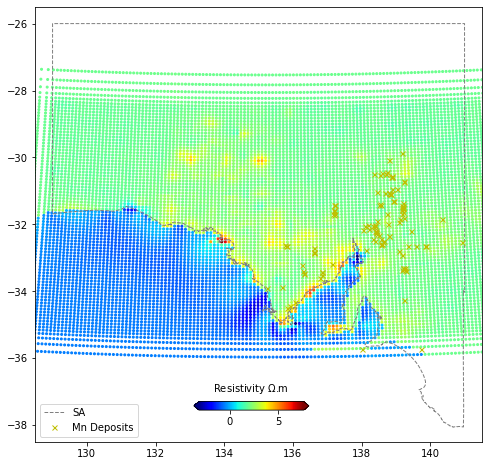

In [10]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
im=ax.scatter(data_res.lon,data_res.lat,s=4,c=data_res.resistivity,cmap="jet")
ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='x', linestyle='',markersize=5, color='y',label=commname+" Deposits")

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)
plt.legend(loc=3)

cbaxes = fig.add_axes([0.40, 0.18, 0.2, 0.015])
cbar = plt.colorbar(im, cax = cbaxes,orientation="horizontal",extend='both')
cbar.set_label('Resistivity $\Omega$.m', labelpad=10)
cbar.ax.xaxis.set_label_position('top')

plt.show()

### Faults and dykes vector polylines

In [13]:
# For dealing with arrays 
import numpy as np

In [14]:
#Get fault data neo
faultshape="data/Faults/Faults.shp"
shapeRead = shapefile.Reader(faultshape)
shapes  = shapeRead.shapes()
Nshp    = len(shapes)

faultsNeo=[]
for i in range(0,Nshp):
    for j in shapes[i].points:
        faultsNeo.append([j[0],j[1]])
faultsNeo=np.array(faultsNeo)
faultsNeo

array([[133.46269605, -27.41825034],
       [133.46770683, -27.42062991],
       [133.4723624 , -27.42259841],
       ...,
       [138.44613353, -35.36560605],
       [138.44160669, -35.36672662],
       [138.43805501, -35.36793484]])

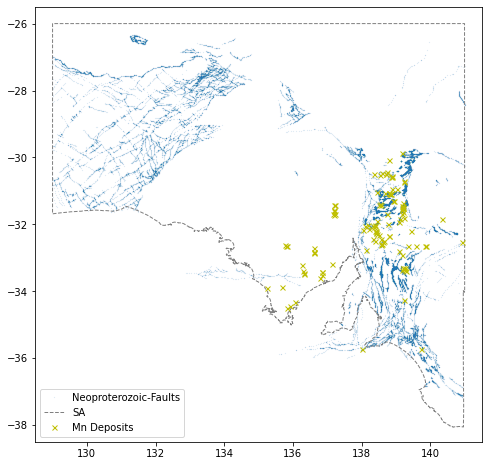

In [15]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
plt.plot(faultsNeo[:,0],faultsNeo[:,1],'.',markersize=0.1,label="Neoproterozoic-Faults")
ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='x', linestyle='',markersize=5, color='y',label=commname+" Deposits")

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)
plt.legend(loc=3)

plt.show()

### Netcdf formatted raster grids - geophysics

In [16]:
# For timing events
import time
# For making grids and reading netcdf data
import scipy
import scipy.io

In [17]:
#Define a function to read the netcdf files
def readnc(filename):
    tic=time.time()
    rasterfile=filename
    data = scipy.io.netcdf_file(rasterfile,'r',mmap=False)
    xdata=data.variables['lon'][:]
    ydata=data.variables['lat'][:]
    zdata=np.array(data.variables['Band1'][:])
    data.close()
    
    toc=time.time()
    print("Loaded", rasterfile, "in", f'{toc-tic:.2f}s')
    print("Spacing x", f'{xdata[2]-xdata[1]:.2f}', 
          "y", f'{ydata[2]-ydata[1]:.2f}', 
          "Shape:", np.shape(zdata), "Min x:", np.min(xdata), "Max x:", np.max(xdata),
          "Min y:", np.min(ydata), f'Max y {np.max(ydata):.2f}')

    return(xdata,ydata,zdata,np.min(xdata),np.min(ydata),xdata[2]-xdata[1],ydata[2]-ydata[1])

In [18]:
# Digital Elevation Model
x1,y1,z1,originx1,originy1,pixelx1,pixely1 = readnc("data/sa-dem.nc")
# Total Magnetic Intensity
x2,y2,z2,originx2,originy2,pixelx2,pixely2 = readnc("data/sa-mag-tmi.nc")
# Gravity
x3,y3,z3,originx3,originy3,pixelx3,pixely3 = readnc("data/sa-grav.nc")

Loaded data/sa-dem.nc in 0.02s
Spacing x 0.01 y 0.01 Shape: (1208, 1201) Min x: 129.005 Max x: 141.005 Min y: -38.065 Max y -25.99
Loaded data/sa-mag-tmi.nc in 0.01s
Spacing x 0.01 y 0.01 Shape: (1208, 1201) Min x: 129.005 Max x: 141.005 Min y: -38.065 Max y -25.99
Loaded data/sa-grav.nc in 0.01s
Spacing x 0.01 y 0.01 Shape: (1208, 1201) Min x: 129.005 Max x: 141.005 Min y: -38.065 Max y -25.99


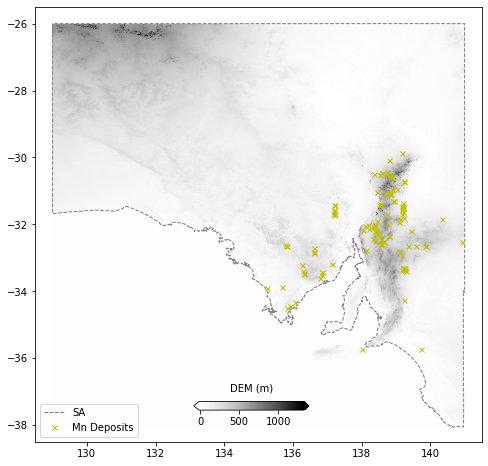

In [19]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
im=plt.pcolormesh(x1,y1,z1,cmap='Greys',shading='auto')
ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='x', linestyle='',markersize=5, color='y',label=commname+" Deposits")

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)
plt.legend(loc=3)

cbaxes = fig.add_axes([0.40, 0.18, 0.2, 0.015])
cbar = plt.colorbar(im, cax = cbaxes,orientation="horizontal",extend='both')
cbar.set_label('DEM (m)', labelpad=10)
cbar.ax.xaxis.set_label_position('top')

plt.show()

### Categorical Geology in vector polygons

In [20]:
#Archean basement geology
geolshape=shapefile.Reader("data/Archaean_Early_Mesoprterzoic_polygons_shp/geology_archaean.shp")

recsArch   = geolshape.records()
shapesArch  = geolshape.shapes()

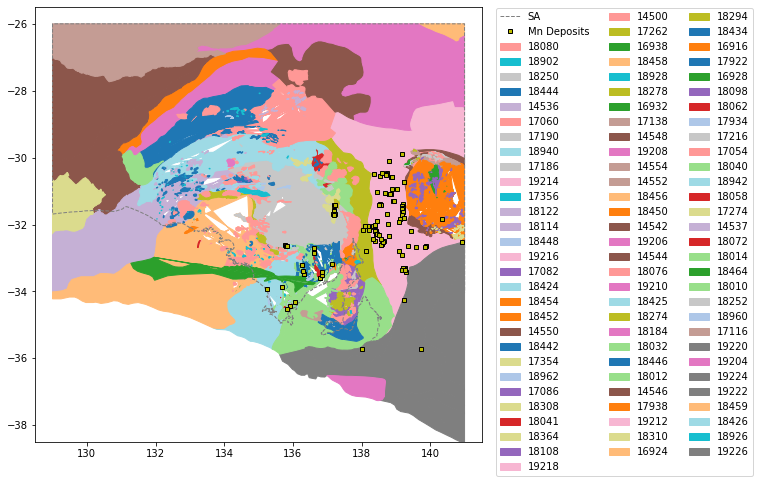

In [21]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes()

#Gather all the unique Major Geology unit numbers
labs=[]
for i in recsArch:
    labs.append(i[-1])

geols = list(set(labs))

# Create a unique color for each geological unit label
color = plt.cm.tab20(np.linspace(0, 1, len(geols)))
cdict={}
for i, geol in enumerate(geols):
    cdict.update({geol:color[i]})
    
#Plot each of the geology polygons
legend1=[]
for i in range(len(shapesArch)):
    boundary = shapesArch[i].points
    xs = [x for x, y in shapesArch[i].points]
    ys = [y for x, y in shapesArch[i].points]
    c = cdict[recsArch[i][-1]]
    l1 = ax.fill(xs,ys,c=c,label=recsArch[i][-1])
    legend1.append(l1)
      
#Plot the extra stuff
l2 = ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
l3 = ax.plot(comm.LONGITUDE, comm.LATITUDE, 
        marker='s', markeredgecolor='k', linestyle='',markersize=4, color='y',
        label=commname+" Deposits")

#Todo: Split the legends
#ax.legend([l2,l3],['SA',commname+" Deposits"],loc=3)

#Legend without duplicate values
handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique), bbox_to_anchor = (1.02, 1.01), ncol=3)

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)
#plt.legend(loc=3) #bbox_to_anchor = (1.05, 0.6))

plt.show()

## Take a moment to appreciate the various methods you have used just to load the data!

Now we need to think about what we actually want to achieve? What is our goal here? This will determine what kind of data analysis/manipulation we need to make here. Consider the flow diagram for [choosing the right machine learning method](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

We need to assign the values of each of these geophyiscal datasets (predictor variables) to the target class (i.e. mineral deposit locations). 
The assumption being that the occurnece of some mineral deposit (e.g. Cu) is a function of x1, x2, x3, x4, x5, x6. 
Where the Resitivity is x1, the distance to a Neoprotezoic fault is x2, the value of DEM, magnetic TMI, and Gravity is x3, x4, and x5, and the geologica basement unit is x6.

In [22]:
# Make a Target DataFrame of the points we want to interrogate the features for
td = comm[['LONGITUDE', 'LATITUDE']].copy()

### Resistivity

In [23]:
# For making KD Trees
import scipy.spatial

In [24]:
# Define a function which "coregisters" a point from a bunch of other points.
def coregPoint(tree,point,region,retval='index'):
    '''
    Finds the nearest neighbour to a point from a bunch of other points
    tree - a scipy CKTree to search for the point over
    point - array([longitude,latitude])
    region - integer, same units as data
    '''
    dists, indexes = tree.query(point,k=1,distance_upper_bound=region) 

    if retval=='index':
        return (indexes)
    elif retval=='dists':
        return(dists)
    

In [25]:
# Find the values of the resetivity grid for each lat/lon deposit location.

# Make a search-tree of the point-pairs for fast lookup of nearest matches
tree = scipy.spatial.cKDTree(np.c_[data_res.lon,data_res.lat])

# Perform the search for each point
indexes = comm.apply(
    lambda x: coregPoint(tree,np.array([x.LONGITUDE, x.LATITUDE]),1,retval='index'), axis=1)

In [26]:
td['res'] = data_res.loc[indexes].resistivity.values
td

,LONGITUDE,LATITUDE,res
0,139.179436,-29.877637,2.2135
1,138.808767,-30.086296,2.3643
2,138.752281,-30.445684,2.1141
3,138.530506,-30.533225,2.2234
4,138.887019,-30.565479,2.1982
...,...,...,...
110,136.059715,-34.327929,3.4926
111,138.016821,-35.733084,2.0868
112,139.250036,-34.250155,1.9811
113,135.905480,-34.425866,2.7108


### Faults

In [27]:
#Same for the fault data 
# but this time we get the "distance to the point", rather than the value at that point.
tree = scipy.spatial.cKDTree(faultsNeo)

dists = comm.apply(
    lambda x: coregPoint(tree,np.array([x.LONGITUDE, x.LATITUDE]),100,retval='dists'), axis=1)

In [28]:
td['faults'] = dists
td

,LONGITUDE,LATITUDE,res,faults
0,139.179436,-29.877637,2.2135,0.010691
1,138.808767,-30.086296,2.3643,0.103741
2,138.752281,-30.445684,2.1141,0.006659
3,138.530506,-30.533225,2.2234,0.013925
4,138.887019,-30.565479,2.1982,0.007356
...,...,...,...,...
110,136.059715,-34.327929,3.4926,0.526835
111,138.016821,-35.733084,2.0868,0.002451
112,139.250036,-34.250155,1.9811,0.027837
113,135.905480,-34.425866,2.7108,0.670323


### Geophysics

In [29]:
# Define a function which "coregisters" a point within a raster.
def get_coords_at_point(originx,originy,pixelx,pixely,lon,lat):
    '''
    Given a point in some coordinate reference (e.g. lat/lon)
    Find the closest point to that in an array (e.g. a raster)
    and return the index location of that point in the raster.
    INPUTS
        "output from "gdal_data.GetGeoTransform()"
    originx: first point in first axis
    originy: first point in second axis
    pixelx: difference between x points
    pixely: difference between y points
    
    lon: x/row-coordinate of interest
    lat: y/column-coordinate of interest
    
    RETURNS
    col: x index value from the raster
    row: y index value from the raster
    '''
    row = int((lon - originx)/pixelx)
    col = int((lat - originy)/pixely)

    return (col, row)

In [30]:
#Perform the search on each of our raster grids
z1list=[]
z2list=[]
z3list=[]
for lon,lat in zip(comm.LONGITUDE,comm.LATITUDE):
    
    coords = get_coords_at_point(originx1,originy1,pixelx1,pixely1,lon,lat)
    z1list.append(z1[coords])
    
    coords = get_coords_at_point(originx2,originy2,pixelx2,pixely2,lon,lat)
    z2list.append(z2[coords])
    
    coords = get_coords_at_point(originx3,originy3,pixelx3,pixely3,lon,lat)
    z3list.append(z3[coords])

#Assign the results
td['dem'] = z1list
td['mag'] = z2list
td['grav'] = z3list

In [31]:
td

,LONGITUDE,LATITUDE,res,faults,dem,mag,grav
0,139.179436,-29.877637,2.2135,0.010691,187.297424,-118.074890,1.852599
1,138.808767,-30.086296,2.3643,0.103741,179.499237,-209.410507,-12.722121
2,138.752281,-30.445684,2.1141,0.006659,398.336823,-159.566422,-6.249788
3,138.530506,-30.533225,2.2234,0.013925,335.983429,-131.176437,-11.665316
4,138.887019,-30.565479,2.1982,0.007356,554.278198,-192.363297,-1.025702
...,...,...,...,...,...,...,...
110,136.059715,-34.327929,3.4926,0.526835,45.866119,-244.067841,11.410070
111,138.016821,-35.733084,2.0868,0.002451,145.452789,-203.566940,18.458364
112,139.250036,-34.250155,1.9811,0.027837,276.489319,-172.889587,-1.714886
113,135.905480,-34.425866,2.7108,0.670323,162.431747,569.713684,15.066316


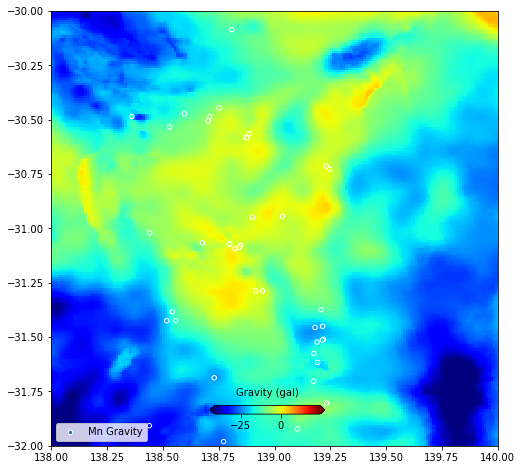

In [32]:
# Check we got it right.
# Plot a grid, and our interrogated points

fig = plt.figure(figsize=(8,8))
ax = plt.axes()
im=plt.pcolormesh(x3,y3,z3,cmap='jet',shading='auto',vmin=min(td.grav),vmax=max(td.grav))
#ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
#ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='o', linestyle='',markersize=5, color='y',label=commname+" Deposits")

ax.scatter(td.LONGITUDE, td.LATITUDE, s=20, c=td.grav,
           label=commname+" Gravity",cmap='jet',vmin=min(td.grav),vmax=max(td.grav),edgecolors='white')

plt.xlim(138,140)
plt.ylim(-32,-30)
plt.legend(loc=3)

cbaxes = fig.add_axes([0.40, 0.18, 0.2, 0.015])
cbar = plt.colorbar(im, cax = cbaxes,orientation="horizontal",extend='both')
cbar.set_label('Gravity (gal)', labelpad=10)
cbar.ax.xaxis.set_label_position('top')

plt.show()

### Geology

In [35]:
# For dealing with shapefile components
from shapely.geometry import Point
from shapely.geometry import shape

#Define a function to find what polygon a point lives inside (speed imporivements can be made here)
def shapeExplore(lon,lat,shapes,recs,record):
    #'record' is the column index you want returned
    for i in range(len(shapes)):
        boundary = shapes[i]
        if Point((lon,lat)).within(shape(boundary)):
            return(recs[i][record])
    #if you have been through the loop with no result
    return(-9999.)

In [36]:
td['geol']=td.apply(lambda x: shapeExplore(x.LONGITUDE, x.LATITUDE, shapesArch,recsArch,-1), axis=1)

In [37]:
td

,LONGITUDE,LATITUDE,res,faults,dem,mag,grav,geol
0,139.179436,-29.877637,2.2135,0.010691,187.297424,-118.074890,1.852599,19214
1,138.808767,-30.086296,2.3643,0.103741,179.499237,-209.410507,-12.722121,19218
2,138.752281,-30.445684,2.1141,0.006659,398.336823,-159.566422,-6.249788,19218
3,138.530506,-30.533225,2.2234,0.013925,335.983429,-131.176437,-11.665316,19218
4,138.887019,-30.565479,2.1982,0.007356,554.278198,-192.363297,-1.025702,19218
...,...,...,...,...,...,...,...,...
110,136.059715,-34.327929,3.4926,0.526835,45.866119,-244.067841,11.410070,18032
111,138.016821,-35.733084,2.0868,0.002451,145.452789,-203.566940,18.458364,19226
112,139.250036,-34.250155,1.9811,0.027837,276.489319,-172.889587,-1.714886,19220
113,135.905480,-34.425866,2.7108,0.670323,162.431747,569.713684,15.066316,17934


# Congrats, you now have an ML dataset ready to go!

Let's explore the data.

In [38]:
# For nice easy data vis plots
import seaborn as sns

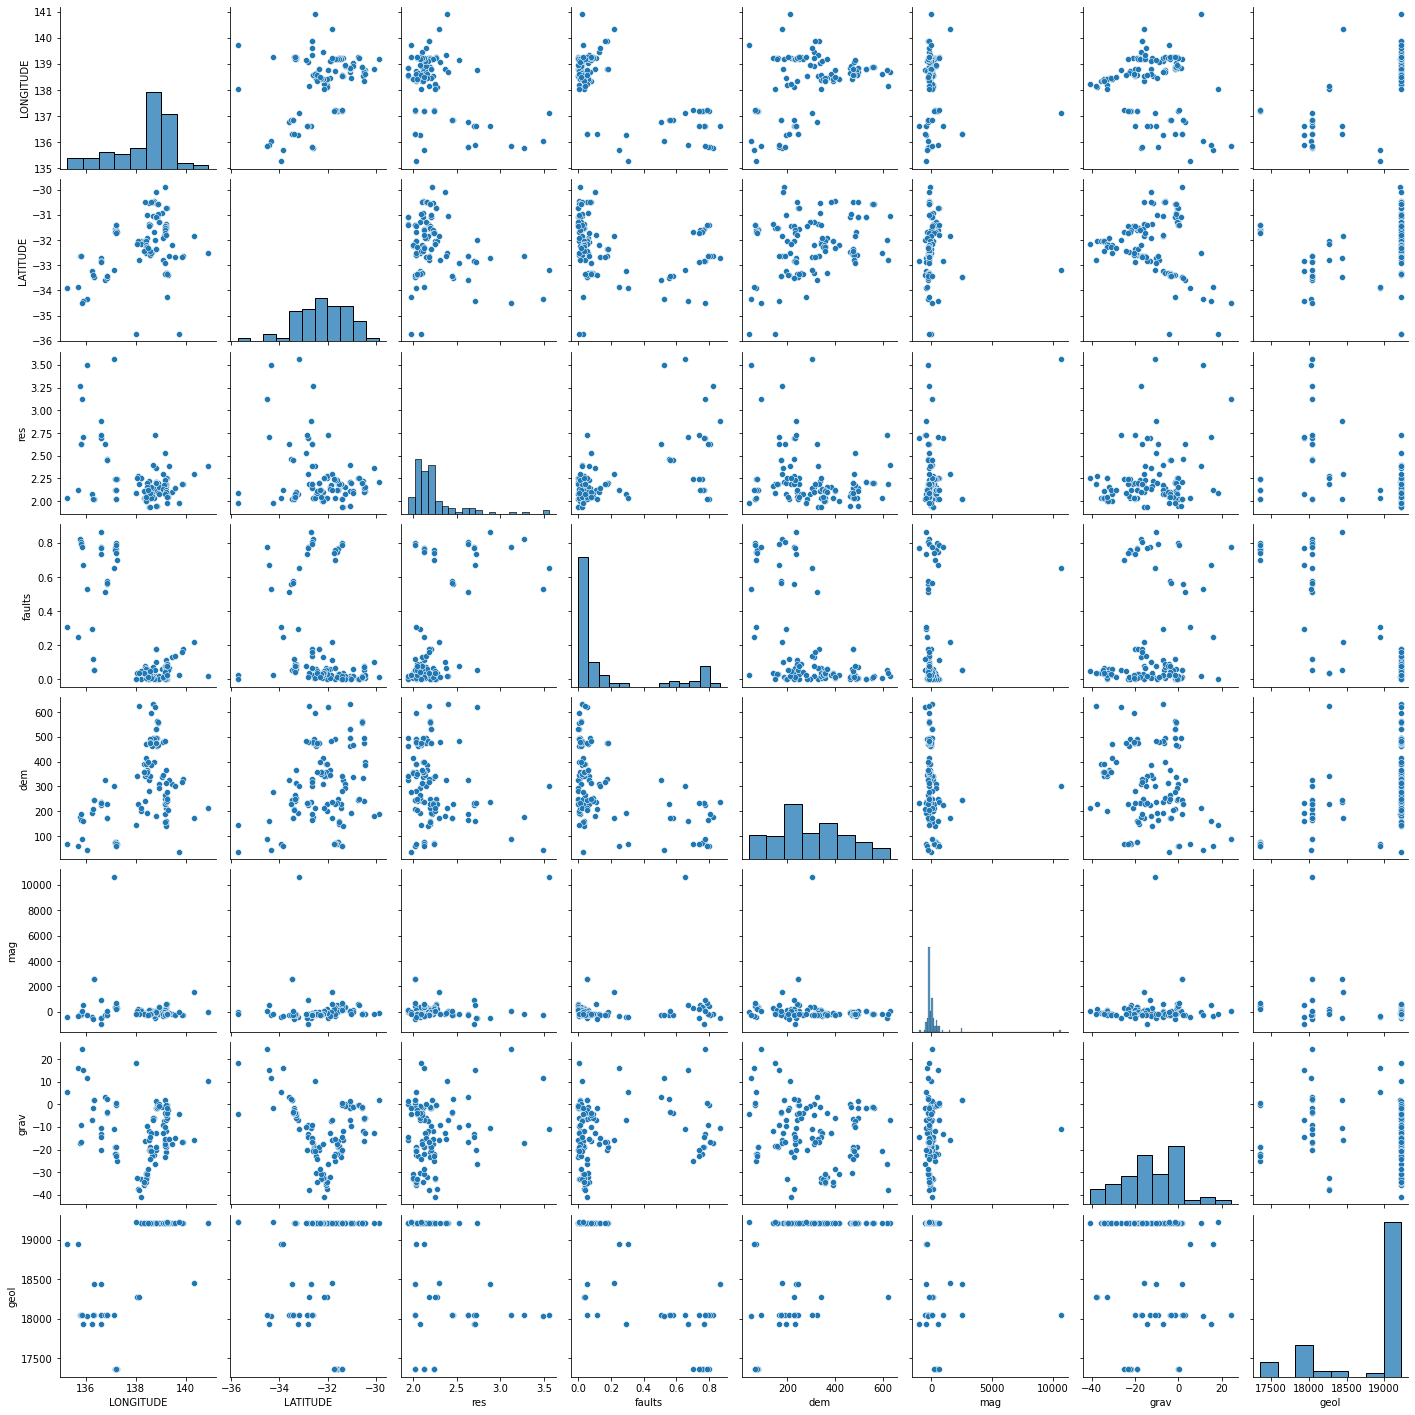

In [39]:
# Plot historgrams and scatter plots for each combination of features.
sns.pairplot(td,palette="Set1",diag_kind="auto")

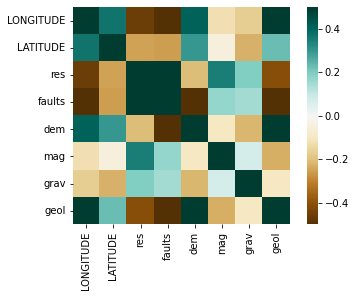

In [40]:
#Plot a heatmap for how correlated each of the features are
corr = td.corr() 

sns.heatmap(corr,
            cmap=plt.cm.BrBG, 
            vmin=-0.5, vmax=0.5, 
            square=True,
            xticklabels=True, yticklabels=True,
            );

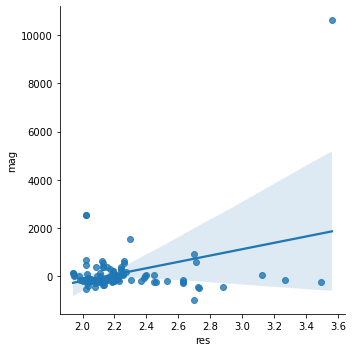

In [41]:
#Plot a regression model through the data
sns.lmplot(
    data = td,
    x = 'res', y = 'mag'
);

# Part 2 - Spatial data mining of datasets

### Select the commodity and geophysical features to use 
Edit *commname* above and turn these labels on/off as required. 
Generally run data mining with all labels. 
Then can turn these features on/off before running ML if needed.

### Generate the non-deposit dataset

This step is important. There are numerous ways to generate our non-deposit set, each with different benefits and trade-offs.
The randomisation of points throughout *some* domain appears to be robust. But you must think, is this domain a reasonable estimation of "background" geophysics/geology? Why are you picking these locations as non-deposits? Will they be over/under-representing actual deposits? Will they be over/under-representing actual non-deposits?

Change the lows, highs, and sizes as desired. And enforce the points are with some confinement area if needed.
A good place to start is within the spatial extent of the known deposits/commodity.

In [86]:
#Generate "non-deposit" points within the same spatial domains as deposits (e.g. on land, or in the gawler, or in SA).
#We may want to train and test just over the regions that the grids are valid.
#So we can crop the known deposits to the extent of the grids.

polgonshape=shapefile.Reader("SA-DATA/SA/SA_STATE_POLYGON_shp.shp")
#polgonshape=shapefile.Reader("SA-DATA/GCAS_Boundary/GCAS_Boundary.shp)
shapesPoly  = polgonshape.shapes()

#Now make a set of "non-deposits" using a random location within our exploration area
lats_rand=np.random.uniform(low=min(df.LATITUDE), high=max(df.LATITUDE), size=len(comm.LATITUDE))
lons_rand=np.random.uniform(low=min(df.LONGITUDE), high=max(df.LONGITUDE), size=len(comm.LONGITUDE))

#And enforce the random points are within our the shapefile boudary
#Probably more efficent ways to do this for larger datasets. Fine for now.
boundary=shapesPoly[1]
for i,_ in enumerate(lats_rand):
    while not Point((lons_rand[i],lats_rand[i])).within(shape(boundary)):
            lats_rand[i]=random.uniform(min(df.LATITUDE), max(df.LATITUDE))
            lons_rand[i]=random.uniform(min(df.LONGITUDE), max(df.LONGITUDE))
            
print("Produced", len(lats_rand),len(lons_rand), "latitude-longitude pairs for non-deposits.")

ShapefileException: Unable to open SA-DATA/SA/SA_STATE_POLYGON_shp.dbf or SA-DATA/SA/SA_STATE_POLYGON_shp.shp.

In [25]:
#Save the SA polygon for plotting
xvalsa = [x[0] for x in shapesPoly[1].points]
yvalsa = [x[1] for x in shapesPoly[1].points]

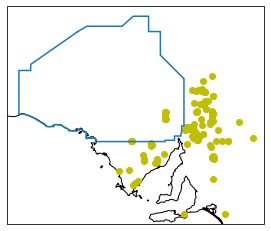

In [68]:
#Quick plot of where commodity deposit data is and generated non-deposit data
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.margins(0.05) # 5% padding to the map boundary so we can see the true extent nicely

ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='o', linestyle='', color='y')
#ax.plot(lons_rand,lats_rand,marker='.',linestyle='',color='k')
plt.plot(xval,yval,label='Gawler')

plt.show()

### Define function which performs coregistering/data-mining

## Run spatial mining of known deposits and "non-deposits"
Must be re-run on each commodity change. Can be saved and just loaded in if data has already been generated.

In [28]:
#Load in co-registerd training data
training_data=pd.read_csv("ML-DATA/training_data-"+commname+".csv",header=0)

#Or if that does not exist run next two cells....

## Run spatial mining of gawler target data
Only needs to be done once. Each commodity uses this same dataset for targetting. The values of the grid are used to predict whatever commodity is run. Depending on target resolution and whether using parallel versions, can take a good amount of time. 

In [31]:
#Load in target data
target_data=pd.read_csv("ML-DATA/target_data.csv",header=0)

#OR run the next 5 cells....

In [ ]:
################ RUN FROM HERE ONCE (or use the HPC versions for high-res) ##########################
#Make a regularly spaced grid here for use in making a probablilty map later
lats_reg=np.linspace(min(yval),max(yval),10)
lons_reg=np.linspace(min(xval),max(xval),10)
#lats_reg=np.arange(min(yval),max(yval)+0.0100,0.0100)
#lons_reg=np.arange(min(xval),max(xval)+0.0100,0.0100)

sampleData=[]
for lat in lats_reg:
    for lon in lons_reg:
            sampleData.append([lat, lon])
            
print(np.size(sampleData))

In [ ]:
#Run the data-mining/coregistration
gridgawler=[]
tic=time.time()
for geophysparams in sampleData:
    #lazy_result = delayed(coregLoop)(geophysparams)
    lazy_result = coregLoop(geophysparams)
    gridgawler.append(lazy_result)
print("appended, now running...")

#c=compute(gridgawler)
toc=time.time()

print("Time taken:", toc-tic, " seconds")

In [ ]:
#Clean up the output file
target_data=pd.DataFrame(np.squeeze(gridgawler),columns=lons+numerical_features+categorical_features)

In [ ]:
#Add the categorical shapefile data
target_data['geol28']=target_data.apply(shapeExplore, args=(shapesGeol,recsGeol,1), axis=1)
target_data['archean27']=target_data.apply(shapeExplore, args=(shapesArch,recsArch,-1), axis=1)

In [ ]:
#Save out the data, and no need to run the co-registration again.
target_data.to_csv("target_data.csv",index=False)

################## RUN TO HERE ONCE #########################

In [32]:
#Look at the target data
#Should be in the same form as the training data WITHOUT the information of whether it is a deposit or non-deposit.
target_data

,lon,lat,res-25,res-77,res-136,res-201,res-273,res-353,res-442,res-541,...,mag20-rtp,mag21-tmi,rad22-dose,rad23-k,rad24-th,rad25-u,grav26,archean27,geol28,random
0,131.000009,-32.664987,-0.8814,-0.8562,-0.7231,-0.5389,-0.3426,-0.1523,0.0268,0.1949,...,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,14536,1002,999.0
1,131.010009,-32.664987,-0.8814,-0.8562,-0.7231,-0.5389,-0.3426,-0.1523,0.0268,0.1949,...,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,14536,1002,999.0
2,131.020009,-32.664987,-0.8814,-0.8562,-0.7231,-0.5389,-0.3426,-0.1523,0.0268,0.1949,...,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,14536,1002,-999.0
3,131.030009,-32.664987,-0.8814,-0.8562,-0.7231,-0.5389,-0.3426,-0.1523,0.0268,0.1949,...,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,14536,1002,999.0
4,131.040009,-32.664987,-0.8814,-0.8562,-0.7231,-0.5389,-0.3426,-0.1523,0.0268,0.1949,...,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,14536,1002,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374161,137.970009,-27.344987,1.9917,1.9870,1.9831,1.9793,1.9749,1.9697,1.9647,1.9629,...,60.714424,77.071075,-9999.0,-9999.0,-9999.0,-9999.0,-36.425686,14548,2030,-999.0
374162,137.980009,-27.344987,1.9917,1.9870,1.9831,1.9793,1.9749,1.9697,1.9647,1.9629,...,58.152508,72.153748,-9999.0,-9999.0,-9999.0,-9999.0,-35.383732,14548,2030,-999.0
374163,137.990009,-27.344987,1.9924,1.9882,1.9849,1.9819,1.9785,1.9746,1.9707,1.9681,...,56.024078,66.960632,-9999.0,-9999.0,-9999.0,-9999.0,-34.756775,14548,2030,999.0
374164,138.000009,-27.344987,1.9924,1.9882,1.9849,1.9819,1.9785,1.9746,1.9707,1.9681,...,53.722004,61.110107,-9999.0,-9999.0,-9999.0,-9999.0,-34.204567,14548,2030,999.0


# Part 3 - Machine learning model

Now we have a fully data-mined, coregistered set of geophysical features. Both for training with known information about our deposits classification labels, and also a target set, we can build and apply the Machine Learning model classifier.

In [33]:
#First, we can check some details about the data. 
#Simple check whether at least MOST of the geophysical parameters have a reasonable value associated with them.
[print(training_data.columns[i],j) for i,j in enumerate(training_data.median())]
#If any of these score -9999.0 it is recommended to remove from that column from analysis
#You can do this, by now "commenting out" the layer in cell 27.

lon 138.24976824878848
lat -31.4234139
res-25 2.0562500000000004
res-77 2.07275
res-136 2.0737
res-201 2.0729
res-273 2.0686
res-353 2.0707
res-442 2.06045
res-541 2.0584
res-650 2.0572999999999997
res-772 2.0549999999999997
res-907 2.0544000000000002
res-1056 2.0513
res-1223 2.05735
res-1407 2.0737
res-1612 2.0917000000000003
res-1839 2.0865
res-2092 2.0808999999999997
res-2372 2.0644
res-2683 2.01925
res-3028 2.0089
res-3411 2.0092999999999996
res-3837 1.9667
res-4309 1.98135
res-4833 1.9901499999999999
res-5414 2.0079000000000002
res-6060 2.1113999999999997
res-6776 2.1632
res-7572 2.252
res-8455 2.3027499999999996
res-9435 2.35195
res-10523 2.4196
res-11730 2.4535
res-13071 2.4711499999999997
res-14559 2.5052
res-16210 2.4838
res-18043 2.4543999999999997
res-20078 2.41535
res-22337 2.3192500000000003
res-24844 2.3199
res-27627 2.33305
res-30716 2.2951
res-34145 2.3369999999999997
res-37951 2.372
res-42175 2.3846499999999997
res-46865 2.4406499999999998
res-52070 2.4587
res-57847 2.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### ML Classification
This is where the ML classifier is defined. We can substitue our favourite ML technique here, and tune model variables as desired. The default choices are recommended for the Gawler region.

In [34]:
#Create the 'feature vector' and a 'target classification vector'
features=training_data[numerical_features+categorical_features]
targets=training_data.deposit

#Create the ML classifier with numerical and categorical data
#Scale, and replace missing values
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(missing_values=-9999., strategy='median')),
    ('scaler', StandardScaler())])

#Encode categorical data and fill missing values with default 0
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#Combine numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
rf = Pipeline(steps=[('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier(random_state=1))])


In [35]:
#You can apply weighting to the model here. 
#We find manual selction (i.e with sound geological reasoning) of deposits is probably more robust 
#than applying arbitrary weighting of class labels. 
#Nevertheless, we can do this if desired by uncommenting and tweaking  the following.

weights=np.ones(len(training_data))
weightcount=0

#Algorithm for setting weight values, point by point
# for i,row in enumerate(training_data[training_data.deposit==1].itertuples()):
#     xloc1=(np.abs(np.array(comm.LONGITUDE) - row.lon).argmin())
#     if comm.loc[xloc1].SIZE_VAL=="Locally Significant":
#         weights[i]=2
#     elif comm.loc[xloc1].SIZE_VAL=="Significant to SA":
#         weights[i]=4
#     elif comm.loc[xloc1].SIZE_VAL=="Significant to Australia":
#         weights[i]=8
#     elif comm.loc[xloc1].SIZE_VAL=="World-wide Significance":
#         weights[i]=16
#     else:
#         #Else keep the weight at 1
#         weightcount+=1
#         weights[i]=0
#         continue
        

    

Tranining the Clasifier...
Done RF. Now scoring...
RF 10-fold cross validation Scores: [0.95652174 0.86956522 1.         0.86956522 0.91304348 0.91304348
 0.7826087  0.86956522 0.82608696 0.69565217]
SCORE Mean: 0.87 STD: 0.08 



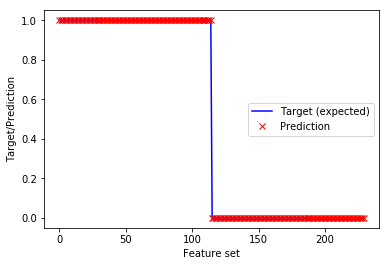

In [36]:
print('Tranining the Clasifier...')
rf.fit(features,targets,**{'classifier__sample_weight': weights})

print("Done RF. Now scoring...")
scores = cross_val_score(rf, features,targets, cv=10)

print("RF 10-fold cross validation Scores:", scores)
print("SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores), "\n")

plt.plot(targets.values,'b-',label='Target (expected)')
plt.plot(rf.predict(features),'rx',label='Prediction')
plt.xlabel("Feature set")
plt.ylabel("Target/Prediction")
plt.legend(loc=7)

In [37]:
#Make a plot out the feature scores. 
#These are the important parameters that are correlated with the deposits.

ft_idx=[]
ft_lab=[]
all_idx=[]
all_lab=[]
all_dat=[]
#Just print the significant features above some threshold
for i,lab in enumerate(np.append(numerical_features,rf['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))):
    all_dat.append([i,lab,rf.steps[1][1].feature_importances_[i]])
    all_lab.append(lab)
    all_idx.append(i)
    if rf.steps[1][1].feature_importances_[i] >1*np.median(rf.steps[1][1].feature_importances_): 
        ft_idx.append(i)
        ft_lab.append(lab)
        

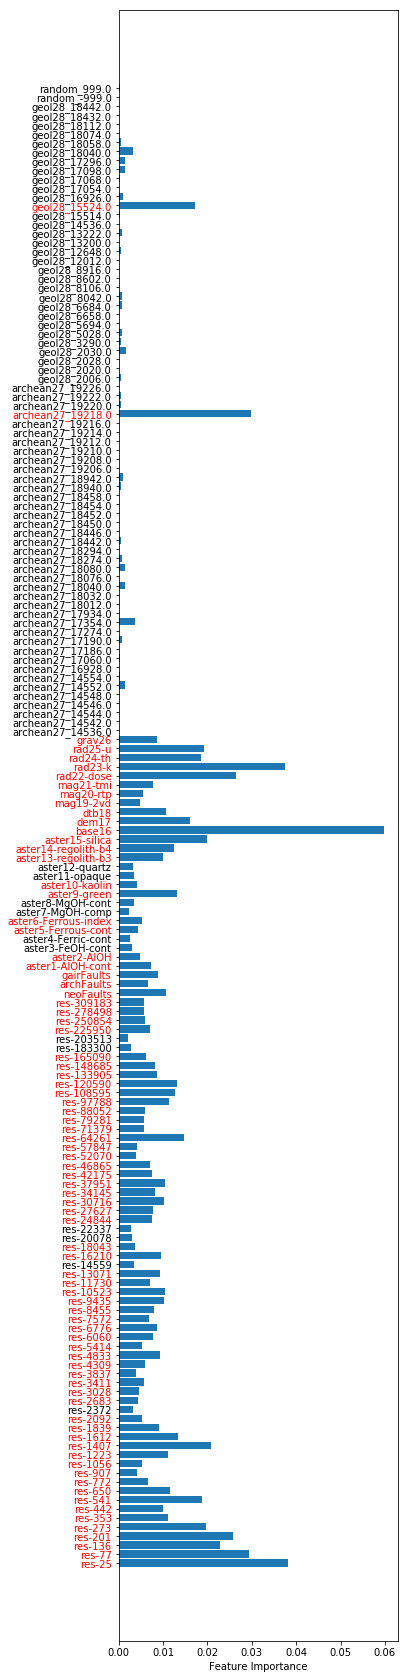

In [38]:
#And plot all the feature importances
#plt.plot(rf.steps[1][1].feature_importances_)

fig, ax = plt.subplots(figsize=(5,30))

ft_imps=rf.steps[1][1].feature_importances_
y_pos=np.arange(len(ft_imps))
ax.barh(y_pos,ft_imps,align='center')

ax.set_yticks(all_idx)
ax.set_yticklabels(all_lab)
ax.yaxis.label.set_color('red')
for i in ft_idx:
    ax.get_yticklabels()[i].set_color("red")

ax.set_xlabel('Feature Importance')

plt.show()

#plt.xticks([0,1,2,3,4,5,7,81,82,83,84,85,86])

RF...
Done RF


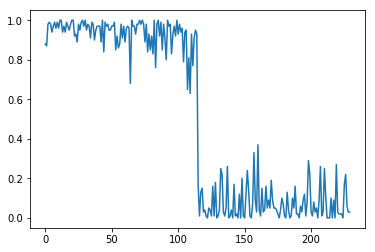

In [39]:
#Chec the probabilities at each of the deposit/non-deposit points
print('RF...')
pRF=np.array(rf.predict_proba(features))
print("Done RF")

plt.plot(pRF[:,1])

## Finally, apply the model to the grid

In [40]:
#Apply the trained ML to our gridded data to determine the probabilities at each of the points
print('RF...')
pRF_map=np.array(rf.predict_proba(target_data[numerical_features+categorical_features]))
print("Done RF")

RF...
Done RF


In [41]:
#Create a meshgrid from our xyz list of points
gridX,gridY,gridZ=grid(target_data.lon, target_data.lat,pRF_map[:,1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: The griddata function was deprecated in Matplotlib 2.2 and will be removed in 3.1. Use scipy.interpolate.griddata instead.


In [310]:
#Save the csv grid of targets
targetCu = {'Longitude': target_data.lon, 'Latitude': target_data.lat, 'Prediction': pRF_map[:,1]}
targetCu=pd.DataFrame(targetCu)
targetCu.to_csv('Targets-'+commname+'.csv',header=0,index=False)

<urlopen error [Errno -5] No address associated with hostname>
<urlopen error [Errno -5] No address associated with hostname><urlopen error [Errno -5] No address associated with hostname>
<urlopen error [Errno -5] No address associated with hostname>
<urlopen error [Errno -5] No address associated with hostname>
<urlopen error [Errno -5] No address associated with hostname>



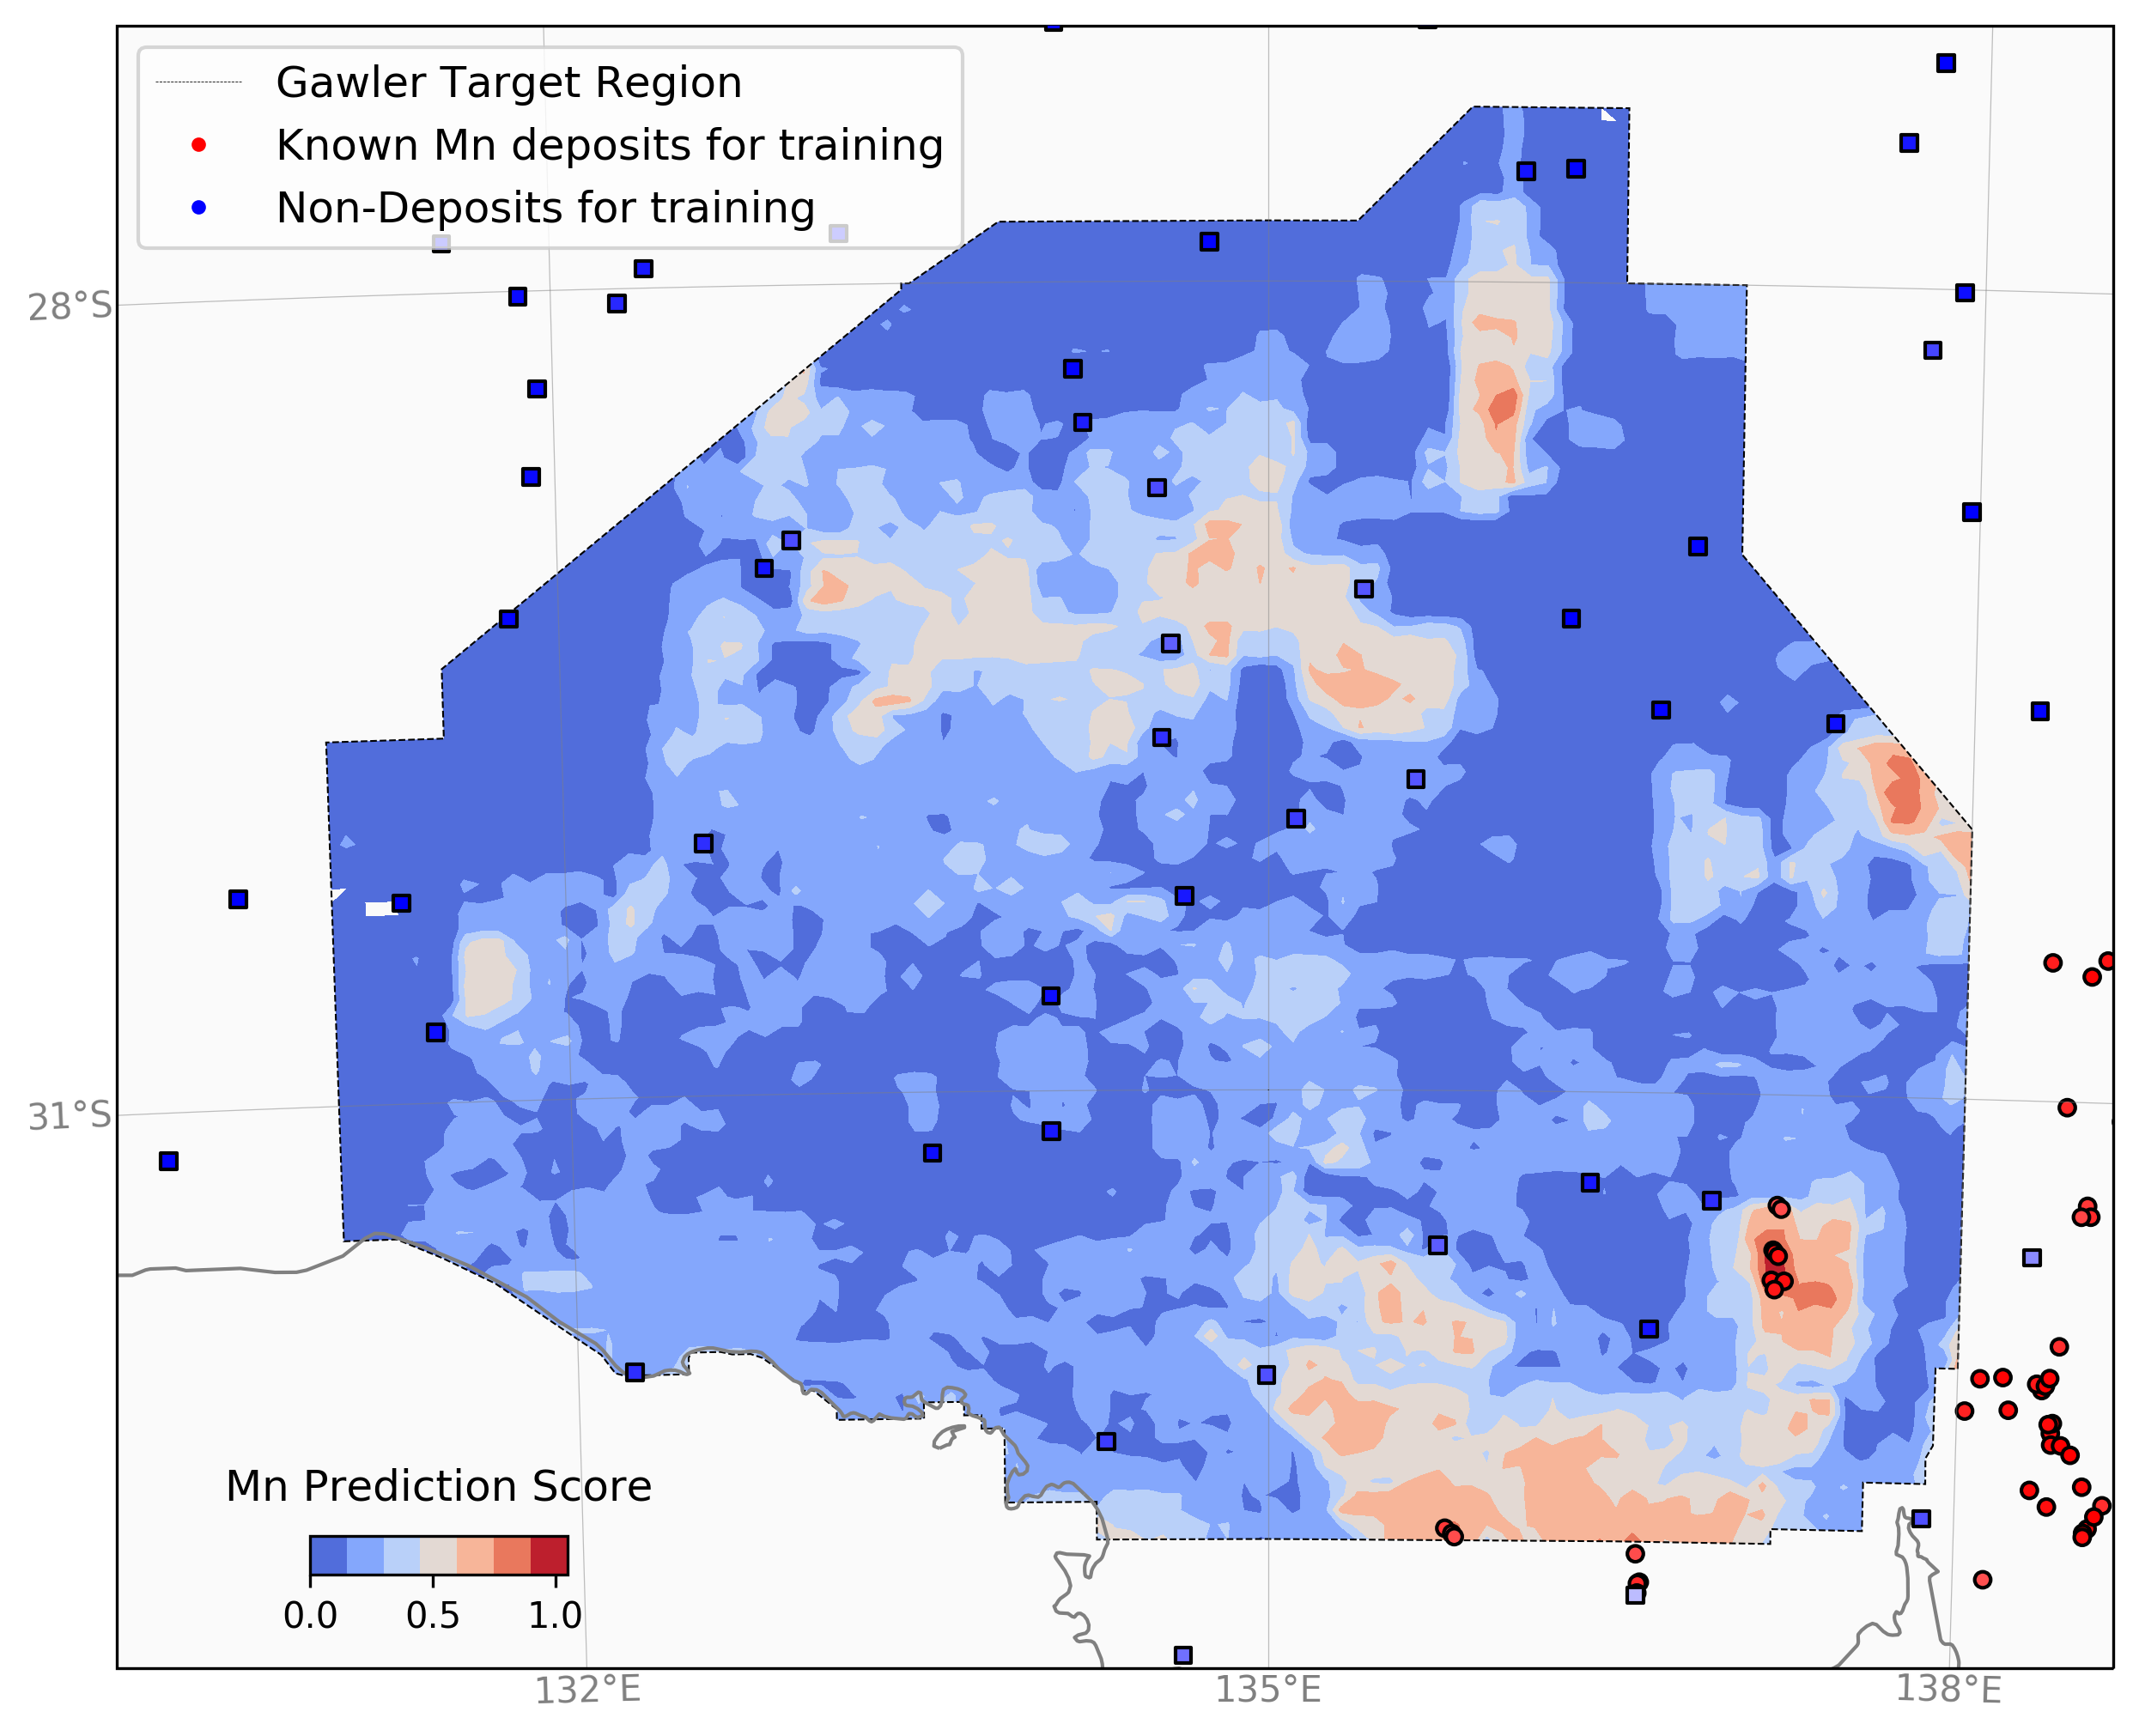

In [42]:
#Plot the final target map
fig = plt.figure(figsize=(10,10),dpi=300)

#Make a map projection to plot on.
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_longitude=135.0, central_latitude=-31.0))
       
#Set the extent of interest
img_extent = [min(df.LONGITUDE)+1.5,  max(df.LONGITUDE)-3.0, min(df.LATITUDE)+5,max(df.LATITUDE)-1]
ax.set_extent(img_extent)

#Put down a base map
ax.coastlines(resolution='10m', color='gray',)
tiler = Stamen('terrain-background')
mercator = tiler.crs
ax.add_image(tiler, 6)

#Make the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.3, color='gray', alpha=0.5, linestyle='-')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
#gl.xlines = False
gl.xlocator = mticker.FixedLocator(list(np.linspace(np.floor(min(df.LONGITUDE))+1,np.ceil(max(df.LONGITUDE))-1,num=5)))
gl.ylocator = mticker.FixedLocator(list(np.linspace(np.floor(min(df.LATITUDE))+1,np.ceil(max(df.LATITUDE))-1,num=5)))
gl.xlocator = mticker.FixedLocator([141,138,135,132,129])
gl.ylocator = mticker.FixedLocator([-38,-34,-31,-28,-26])
#gl.ylocator = mticker.FixedLocator(list(np.linspace(-28,-35,num=3)))
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = {'size': 10, 'color': 'gray'}
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#Create a patch of the gawler region where the data is
path=Path(list(zip(xval, yval)))
patch = PathPatch(path, facecolor='none',transform = ccrs.PlateCarree(),linestyle='--',linewidth=0.5)
plt.gca().add_patch(patch)

#Plot the main map
im=ax.contourf(gridX,gridY,gridZ,cmap=plt.cm.coolwarm,transform = ccrs.PlateCarree(),vmin=0,vmax=1)
#im = ax.imshow(gridZ, interpolation='bicubic', cmap=plt.cm.bwr,
#                origin='lower', extent=[np.min(gridX),np.max(gridX),np.min(gridY),np.max(gridY)],
#                clip_path=patch, clip_on=True,zorder=1,transform = ccrs.PlateCarree())
for c in im.collections:
    c.set_clip_path(patch)
    
# l5=ax.scatter(commall.LONGITUDE, commall.LATITUDE, 
#               edgecolor='k',s=10,marker='d', linewidths=0.5,label="",
#               c='r',cmap=plt.cm.bwr,vmin=0,vmax=1,zorder=2,transform = ccrs.PlateCarree())

#Add the deposits coloured by their classification score
l4=ax.scatter(training_data.lon[training_data.deposit==0], training_data.lat[training_data.deposit==0],
               edgecolor='k',s=20,marker='s', linewidths=1,label="",
               c=pRF[lendep:,1],cmap=plt.cm.bwr,vmin=0,vmax=1,zorder=3,transform = ccrs.PlateCarree())

l3=ax.scatter(training_data.lon[training_data.deposit==1], training_data.lat[training_data.deposit==1], 
              edgecolor='k',s=20,marker='o', linewidths=1,label="",
              c=pRF[:lendep,1],cmap=plt.cm.bwr,vmin=0,vmax=1,zorder=2,transform = ccrs.PlateCarree())

#Plot the outline of the Gawler region
ax.plot(xval,yval,'k--',label='Gawler Target Region',linewidth=0.2)
ax.plot(0,0,'r.',label='Known '+commname+' deposits for training',zorder=3,transform = ccrs.PlateCarree())
ax.plot(0,0,'b.',label='Non-Deposits for training',zorder=3,transform = ccrs.PlateCarree())
#ax.plot(0,0,'rd',label='All other Au deposits (not used for training)',zorder=3,transform = ccrs.PlateCarree())

# ax.plot(xlons,xlats,'y-',label='Central Gawler Au Province',zorder=3,transform = ccrs.PlateCarree())
# ax.plot(xlons2,xlats2,'g-',label='Olympic IOCG Province',zorder=3,transform = ccrs.PlateCarree())

# ax.plot(xval,yval,'k--',label='Gawler Target Region',linewidth=0.5,zorder=2,transform = ccrs.PlateCarree())

# Add a map title, legend, colorbar
#plt.title('Known deposits and predictive map for Gawler region, SA')
ax.legend(loc=2,fontsize=12)
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')

#Make a Colorbar
# cbaxes = fig.add_axes([0.16, 0.27, 0.25, 0.015])
# cbar = plt.colorbar(l3, cax = cbaxes,orientation="horizontal")
# cbar.set_label(commname+' prediction')

cbaxes = fig.add_axes([0.20, 0.22, 0.1, 0.015])
cbar = plt.colorbar(im, cax = cbaxes,orientation="horizontal", ticks=[0.0,0.5,1])
# # #cbar.ax.set_xticklabels(['Medium','High'],fontsize=8)
cbar.set_label(commname+' Prediction Score', labelpad=10,fontsize=12)
cbar.ax.xaxis.set_label_position('top')

plt.show()

In [ ]:
# Import numpy for array processing
import numpy as np

df['SIZE_VAL_cat']=df.SIZE_VAL.astype('category').cat.codes
# print(df.SIZE_VAL.astype('category').cat.categories)
df.SIZE_VAL_cat.plot.hist()

# Lets categorise each of the mineral occurences. We can use these as our targets
df['SIZE_VAL_cat'] = np.where(df['SIZE_VAL']=='', 0, df['SIZE_VAL_cat'])
df['SIZE_VAL_cat'] = np.where(df['SIZE_VAL']=='Low Significance', 0, df['SIZE_VAL_cat'])
df['SIZE_VAL_cat'] = np.where(df['SIZE_VAL']=='Locally Significant', 1, df['SIZE_VAL_cat'])
df['SIZE_VAL_cat'] = np.where(df['SIZE_VAL']=='Significant to Australia', 1, df['SIZE_VAL_cat'])
df['SIZE_VAL_cat'] = np.where(df['SIZE_VAL']=='Significant to SA', 1, df['SIZE_VAL_cat'])
df['SIZE_VAL_cat'] = np.where(df['SIZE_VAL']=='World-wide Significance', 1, df['SIZE_VAL_cat'])


import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
im=ax.scatter(df.LONGITUDE,df.LATITUDE,s=5+df.SIZE_VAL_cat.astype(float)*5,c=df.SIZE_VAL_cat,cmap='bwr')
ax.plot(xval,yval,'grey',linestyle='--',linewidth=1,label='SA')
#ax.plot(comm.LONGITUDE, comm.LATITUDE, marker='o', linestyle='',markersize=5, color='y',label=commname+" Deposits")

plt.xlim(128.5,141.5)
plt.ylim(-38.5,-25.5)
plt.legend(loc=3)

cbaxes = fig.add_axes([0.40, 0.18, 0.2, 0.015])
cbar = plt.colorbar(im, cax = cbaxes,orientation="horizontal",extend='neither')
cbar.set_label('Mines and Minerals Significance', labelpad=10)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.set_xticklabels(['Low','','High'],fontsize=8)

plt.show()